# Técnicas de Deep Learning - Microproyecto 3 - Transformers fine tuning

Este proyecto tiene como objetivo, la clasificación de artículos del dataset de la BBC que está en Kaggle https://www.kaggle.com/datasets/jacopoferretti/bbc-articles-dataset, haciendo fine tunning del modelo BERT. La clasificación de los artículos va a hacerse por categorías en cuanto al tema:

# Exploración y Perfilamiento de Datos

En esta sección tenemos las sentencias necesarias para la preparación de librerías, así como la exploración básica del dataset.

##  Cargue de los datos, librerías y modelos necesarios

En esta sección vamos a cargar los datos originales y las librerías requeridas.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transformers as trs
import torch
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_dir = "."
file_path = os.path.join(data_dir, "bbc.csv")

In [ ]:
bbc_df = pd.read_csv(file_path)

In [ ]:
# Cargando el modelo "cased"
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer_bert = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
model_bert= AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-cased")

Some weights of the model checkpoint at google-bert/bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
!pip install hf_xet

## Exploración del dataset

Una vez cargado el dataset, nos damos cuenta de que las etiquetas ya existen en él. Se trata de un dataset pequeño, lo cual lo hace manejable. Dado que tenemos las etiquetas, esto nos permite hacer una clasificación verificable como Machine Learning Supervisado.

In [ ]:
bbc_df

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...
...,...,...,...,...,...,...,...
2122,New consoles promise big problems\n\nMaking ga...,tech,52,60.85,9.20,Instead of employing lots of artists to create...,Mr Wright said that enabling players to devise...
2123,BT program to beat dialler scams\n\nBT is intr...,tech,17,56.29,9.23,If a bill rises substantially above its usual ...,BT is introducing two initiatives to help beat...
2124,Be careful how you code\n\nA new European dire...,tech,45,56.29,8.73,"If it gets its way, the Dutch government will ...",A new European directive could put software wr...
2125,US cyber security chief resigns\n\nThe man mak...,tech,16,47.42,9.14,Amit Yoran was director of the National Cyber ...,The man making sure US computer networks are s...


In [ ]:
bbc_df.describe()

,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score
count,2127.000000,2127.000000,2127.000000
mean,18.968030,63.645548,9.145581
std,13.022952,8.466323,0.823067
min,4.000000,33.410000,6.400000
25%,12.000000,58.210000,8.630000
50%,17.000000,63.430000,9.130000
75%,23.000000,69.310000,9.650000
max,252.000000,87.760000,14.200000


In [ ]:
bbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   text                          2127 non-null   object 
 1   labels                        2127 non-null   object 
 2   no_sentences                  2127 non-null   int64  
 3   Flesch Reading Ease Score     2127 non-null   float64
 4   Dale-Chall Readability Score  2127 non-null   float64
 5   text_rank_summary             2127 non-null   object 
 6   lsa_summary                   2127 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 116.4+ KB


Vemos que no hay datos nulos.

In [ ]:
bbc_df.isna().sum()

,0
text,0
labels,0
no_sentences,0
Flesch Reading Ease Score,0
Dale-Chall Readability Score,0
text_rank_summary,0
lsa_summary,0


Verificamos que no hay duplicados.

In [ ]:
bbc_df.duplicated().sum()

np.int64(0)

Por otra parte vemos la distribución de las categorías

<Axes: xlabel='labels'>

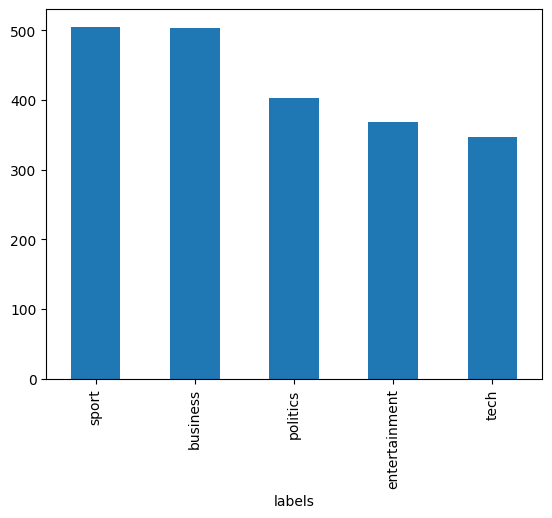

In [ ]:
bbc_df['labels'].value_counts().plot(kind='bar')

Vemos que hay labels que son más numerosas en el dataset: sport y business. Por lo que para hacer que esta distribución no tenga efecto, vamos a usar stratify en la partición de los conjuntos de prueba y validación.

Ya que no necesitamos las demás columnas, elegimos sólo las columnas text y labels.

In [ ]:
data = bbc_df.copy()

In [ ]:
data = data[['text','labels']]

In [ ]:
data

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...
2122,New consoles promise big problems\n\nMaking ga...,tech
2123,BT program to beat dialler scams\n\nBT is intr...,tech
2124,Be careful how you code\n\nA new European dire...,tech
2125,US cyber security chief resigns\n\nThe man mak...,tech


Hemos guardado los textos tokenizados en otra columna del set de datos.

Realizamos el encoding de los labels

# Creación del pipeline y clases utiliatarias

Este notebook entrena y evalúa modelos basados en BERT para clasificar artículos en 5 categorías:
- politics, sport, business, tech, entertainment

Incluye opciones configurables:
- Usar BERT sin entrenamiento adicional
- Fine-tuning completo de BERT
- BERT con red de clasificación configurable
- BERT congelado con red de clasificación

In [ ]:

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [ ]:
# 1. Dataset
class BBCDataset(Dataset):
    """
    Dataset personalizado para artículos de la BBC.

    Esta clase tokeniza los textos usando BERTTokenizer y prepara los tensores
    necesarios para el entrenamiento y evaluación de modelos BERT.

    Atributos:
        texts (list): Lista de textos/artículos.
        labels (list): Etiquetas asociadas a cada texto.
        tokenizer (transformers.BertTokenizer): Tokenizador BERT.
        max_len (int): Longitud máxima permitida para cada secuencia.

    Retorna:
        Dict con:
            - input_ids: Tensor de tokens.
            - attention_mask: Tensor de máscara de atención.
            - labels: Tensor con la clase objetivo.
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# 2. Modelo con capa configurable
class BERTClassifier(nn.Module):
    """
    Modelo BERT con red de clasificación configurable.

    Este modelo extiende BERT con una red completamente conectada con activación ReLU
    y dropout configurable para tareas de clasificación de texto.

    Args:
        dropout_rate (float): Tasa de dropout a aplicar entre capas.
        hidden_dim (int): Número de unidades en la capa oculta intermedia.
        num_classes (int): Número de clases a predecir.

    forward(input_ids, attention_mask):
        input_ids: Tensor de tokens.
        attention_mask: Tensor de atención.
        returns: Logits para cada clase.
    """
    def __init__(self, dropout_rate, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, hidden_dim)
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout(outputs.pooler_output)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)


## 2. Definición del pipeline BERT

Incluye dataset personalizado, modelo configurable y lógica de entrenamiento/evaluación por fold.

Esta clase contiene todos los métodos necesarios para hacer la comparación entre los diferentes enfoques de entrenamiento, de tal manera que podamos configurarlo más adelante.

Los modos(enfoques) disponibles son los siguientes:

  Modos disponibles:
  * 'bert_only': usa embeddings de BERT con clasificador tradicional.
  * 'bert_finetune': fine-tuning completo de BERT con capa lineal.
  * 'bert_with_head': BERT + red densa personalizada.
  * 'bert_frozen_head': BERT congelado + red densa personalizada.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import display

In [ ]:

class BERTPipeline():

    '''
      Pipeline para entrenamiento y evaluación de modelos BERT en tareas de clasificación de texto.

      Modos disponibles:
      - 'bert_only': usa embeddings de BERT con clasificador tradicional.
      - 'bert_finetune': fine-tuning completo de BERT con capa lineal.
      - 'bert_with_head': BERT + red densa personalizada.
      - 'bert_frozen_head': BERT congelado + red densa personalizada.
    '''
    def __init__(self, config):
      self.max_len = config['max_len']
      self.batch_size = config['batch_size']
      self.epochs = config['epochs']
      self.lr = config['lr']
      self.dropout = config['dropout']
      self.hidden_dim = config['hidden_dim']
      self.num_folds = config['num_folds']
      self.mode = config['mode']
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
      self.fold_results = []
      self.reports = []           # Para guardar los classification_report por fold
      self.preds_by_fold = []     # Para guardar las predicciones reales y predichas por
      self.all_reports_df = pd.DataFrame()
      self.all_preds_df = pd.DataFrame()
      self.fold_summary_df = pd.DataFrame()
      self.accuracies = []
      self.df = pd.DataFrame()
      self.texts = []
      self.labels = []
      self.label_encoder = LabelEncoder()
      self.model_final = None
      self.classifier_final = None


    def get_device(self):
        return self.device

    def load_dataframe(self, df, text_column='text', label_column='labels'):
        from sklearn.preprocessing import LabelEncoder
        """
        Carga los datos desde un DataFrame, codifica las etiquetas y prepara texto y etiquetas.
        """
        from sklearn.preprocessing import LabelEncoder

        self.df = df.copy()
        self.text_column = text_column
        self.label_column = label_column

        # Asegurar que las etiquetas sean texto
        self.df[label_column] = self.df[label_column].astype(str)

        # Codificar etiquetas
        self.label_encoder = LabelEncoder()
        self.df['label_encoded'] = self.label_encoder.fit_transform(self.df[label_column])

        # Guardar listas listas para splits
        self.texts = self.df[text_column].tolist()
        self.labels = self.df['label_encoded'].tolist()

    def get_embeddings(self, texts):
        model = BertModel.from_pretrained('bert-base-uncased').to(self.device)
        model.eval()
        embeddings = []
        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len).to(self.device)
                outputs = model(**inputs)
                cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
                embeddings.append(cls_embedding)
        return np.vstack(embeddings)

    def summarize_folds(self, mode):
        """
        Muestra y guarda el resumen de métricas por fold, incluyendo accuracy
        y etiquetando cada fold con el modo de entrenamiento ('scenario').
        Siempre genera dataframes bien estructurados, aunque estén vacíos.
        """
        expected_columns = ['Fold','Clase','precision', 'recall', 'f1-score', 'support', 'accuracy', 'scenario']

        if not self.reports:
            print("No hay reportes generados aún.")
            self.fold_summary_df = pd.DataFrame(columns=expected_columns)
            self.all_preds_df = pd.DataFrame()
            return

        # Concatenar los reportes
        reports_concat = pd.concat(self.reports)

        # Promedio por fold
        summary = reports_concat.groupby('Fold')[['precision', 'recall', 'f1-score', 'support']].mean()

        # Agregar accuracy
        if hasattr(self, 'accuracies') and len(self.accuracies) == len(summary):
            summary['accuracy'] = self.accuracies

        # Agregar nombre del escenario
        summary['scenario'] = mode
        reports_concat['scenario'] = mode

        # Guardar
        self.fold_summary_df = summary.reset_index()
        self.all_reports_df= pd.concat([self.all_reports_df,reports_concat],ignore_index=True)

        print("=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===")
        display(self.fold_summary_df)


        print("=== Todas las métricas por Fold ===")
        display(self.all_reports_df.round(3))

        # Guardar predicciones por fold
        if self.preds_by_fold:
            all_preds = pd.concat(self.preds_by_fold)
            all_preds['scenario'] = mode
            self.all_preds_df = all_preds
        else:
            self.all_preds_df = pd.DataFrame(columns=['Fold', 'y_true', 'y_pred', 'scenario'])



    def train_and_evaluate(self):
        """
        Ejecuta entrenamiento y evaluación por validación cruzada para clasificación de texto con BERT.

        Realiza:
        - División en folds (StratifiedKFold)
        - Entrenamiento por fold en el modo especificado
        - Evaluación y visualización por fold
        - Almacenamiento de métricas, predicciones y matrices de confusión
        - Resumen global de métricas al finalizar
        """

        skf = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=42)
        for fold, (train_idx, val_idx) in enumerate(skf.split(self.texts, self.labels)):
            print(f"===== Fold {fold+1} =====")

            X_train = self.df.iloc[train_idx][self.text_column].tolist()
            y_train = self.df.iloc[train_idx]["label_encoded"].tolist()
            X_val   = self.df.iloc[val_idx][self.text_column].tolist()
            y_val   = self.df.iloc[val_idx]["label_encoded"].tolist()
            model = None
            if self.mode == 'bert_only':
                print("[Modo: BERT sin entrenamiento adicional]")
                X_train_embed = self.get_embeddings(X_train)
                X_val_embed = self.get_embeddings(X_val)
                clf = LogisticRegression(max_iter=2000)
                clf.fit(X_train_embed, y_train)
                y_pred = clf.predict(X_val_embed)
                y_true = y_val

                report_df = self.classification_report(y_true, y_pred, fold)
                self.reports.append(report_df)


                self.preds_by_fold.append(pd.DataFrame({
                    'Fold': fold + 1,
                    'y_true': y_true,
                    'y_pred': y_pred
                }))


                self.confusion_matrix(y_true, y_pred, fold)
                continue

            train_dataset = BBCDataset(X_train, y_train, self.tokenizer,self.max_len)
            val_dataset = BBCDataset(X_val, y_val, self.tokenizer,self.max_len)
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

            if self.mode == 'bert_finetune':
                print("[Modo: BERT con fine-tuning (sin capa adicional)]")
                model = BertModel.from_pretrained('bert-base-uncased')
                classifier = nn.Linear(model.config.hidden_size, len(self.label_encoder.classes_)).to(self.device)
                model = model.to(self.device)
                parameters = list(model.parameters()) + list(classifier.parameters())
            elif self.mode == 'bert_with_head':
                print("[Modo: BERT + red de clasificación]")
                model = BERTClassifier(self.dropout, self.hidden_dim, num_classes=len(self.label_encoder.classes_)).to(self.device)
                parameters = model.parameters()
            elif self.mode == 'bert_frozen_head':
                print("[Modo: BERT congelado + red de clasificación]")
                model = BERTClassifier(self.dropout, self.hidden_dim, num_classes=len(self.label_encoder.classes_)).to(self.device)
                for param in model.bert.parameters():
                    param.requires_grad = False
                parameters = filter(lambda p: p.requires_grad, model.parameters())
            else:
                raise ValueError("Modo de entrenamiento no soportado")

            optimizer = torch.optim.AdamW(parameters, lr=self.lr)
            criterion = nn.CrossEntropyLoss()
            train_losses = []
            model.train()
            for epoch in range(self.epochs):
                total_loss = 0
                for batch in train_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels_batch = batch['labels'].to(self.device)
                    optimizer.zero_grad()
                    if self.mode == 'bert_finetune':
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
                        logits = classifier(outputs)
                    else:
                        logits = model(input_ids, attention_mask)
                    loss = criterion(logits, labels_batch)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                avg_loss = total_loss / len(train_loader)
                train_losses.append(avg_loss)

                model.eval()
                y_true_acc, y_pred_acc = [], []
                with torch.no_grad():
                    for batch in val_loader:
                        input_ids = batch['input_ids'].to(self.device)
                        attention_mask = batch['attention_mask'].to(self.device)
                        labels_batch = batch['labels'].to(self.device)
                        if self.mode == 'bert_finetune':
                            outputs = model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
                            logits = classifier(outputs)
                        else:
                            logits = model(input_ids, attention_mask)
                        preds = torch.argmax(logits, dim=1)
                        y_true_acc.extend(labels_batch.cpu().numpy())
                        y_pred_acc.extend(preds.cpu().numpy())
                acc = accuracy_score(y_true_acc, y_pred_acc)
                print(f"Epoch {epoch+1}/{self.epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")

            model.eval()
            y_true, y_pred = [], []
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels_batch = batch['labels'].to(self.device)
                    if self.mode == 'bert_finetune':
                        outputs = model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
                        logits = classifier(outputs)
                    else:
                        logits = model(input_ids, attention_mask)
                    preds = torch.argmax(logits, dim=1)
                    y_true.extend(labels_batch.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())

            report_df = self.classification_report(y_true, y_pred, fold)
            self.reports.append(report_df)

            self.preds_by_fold.append(pd.DataFrame({
                'Fold': fold + 1,
                'y_true': y_true,
                'y_pred': y_pred
            }))

            self.confusion_matrix(y_true, y_pred, fold)

        #Guardando el modelo final para posterior evaluación
        self.model_final = clf if self.mode == 'bert_only' else model
        self.classifier_final = classifier if self.mode == 'bert_finetune' else None
        #Guardando un resumen del fold
        self.summarize_folds(self.mode)


    def confusion_matrix(self, y_true  ,y_pred, fold, normalize='true'):
      """
      Genera matriz de confusión normalizada con nombres de clases.
      """
      if isinstance(y_true[0], (int, np.integer)):
          y_true_labels = self.label_encoder.inverse_transform(np.array(y_true))
      else:
          y_true_labels = y_true

      if isinstance(y_pred[0], (int, np.integer)):
          y_pred_labels = self.label_encoder.inverse_transform(np.array(y_pred))
      else:
          y_pred_labels = y_pred

      class_names = self.label_encoder.classes_

      # Calcular matriz
      cm = confusion_matrix(
          y_true_labels,
          y_pred_labels,
          labels=class_names,
          normalize=normalize
      )

      # Visualizar
      plt.figure(figsize=(6, 5))
      sns.heatmap(
          cm,
          annot=True,
          fmt=".2f",
          xticklabels=class_names,
          yticklabels=class_names,
          cmap="Blues"
      )
      plt.title(f"Matriz de confusión - Fold {fold + 1}")
      plt.xlabel("Predicción")
      plt.ylabel("Real")
      plt.tight_layout()
      plt.show()

    def classification_report(self,y_true, y_pred, fold):
        """
        Genera un reporte de clasificación global.
        """
        if isinstance(y_true[0], (int, np.integer)):
            y_true_labels = self.label_encoder.inverse_transform(np.array(y_true))
        else:
            y_true_labels = y_true

        if isinstance(y_pred[0], (int, np.integer)):
            y_pred_labels = self.label_encoder.inverse_transform(np.array(y_pred))
        else:
            y_pred_labels = y_pred


        report = classification_report(
            y_true_labels,
            y_pred_labels,
            labels=self.label_encoder.classes_,
            target_names=self.label_encoder.classes_,
            output_dict=True
        )

        report_df = pd.DataFrame(report).transpose().reset_index()
        report_df.rename(columns={'index': 'Clase'}, inplace=True)
        report_df['Fold'] = fold + 1



        # Si accuracy no es un dict, lo convertimos a fila compatible
        if 'accuracy' in report and not isinstance(report['accuracy'], dict):
            report_df.loc['accuracy'] = {
                'precision': report['accuracy'],
                'recall': report['accuracy'],
                'f1-score': report['accuracy'],
                'support': report_df['support'].sum(),  # total de muestras
                'Fold': fold + 1
            }

            # Guardar accuracy global en la lista del pipeline
            self.accuracies.append(report['accuracy'])

        print(f"\nReporte de métricas para el Fold {fold + 1}")
        print(report_df[['precision', 'recall', 'f1-score', 'support']].round(3))

        return report_df

    def evaluate_test(self, df_test):

        # Preparar datos
        texts = df_test[self.text_column].tolist()
        labels = self.label_encoder.transform(df_test[self.label_column].astype(str))

        # === CASO ESPECIAL: bert_only ===
        if self.mode == 'bert_only':
            print("[Modo: BERT only + regresión logística (sklearn)]")

            # 1. Extraer embeddings con BERT sin fine-tuning
            X_test_embed = self.get_embeddings(texts)

            # 2. Usar el modelo de sklearn (LogisticRegression entrenado)
            y_pred = self.model_final.predict(X_test_embed)
            y_true = labels

        # === CASOS NORMALES: modelos en PyTorch ===
        else:
            print(f"[Modo: {self.mode} (modelo PyTorch)]")

            if self.model_final is None:
                raise ValueError("self.model_final es None. ¿Ejecutaste train_and_evaluate()?")

            test_dataset = BBCDataset(texts, labels, self.tokenizer, self.max_len)
            test_loader = DataLoader(test_dataset, batch_size=self.batch_size)
            self.model_final.eval()

            y_true, y_pred = [], []
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)

                    if self.mode == 'bert_finetune':
                        outputs = self.model_final(input_ids=input_ids, attention_mask=attention_mask).pooler_output
                        logits = self.classifier_final(outputs)
                    else:
                        logits = self.model_final(input_ids, attention_mask)

                    preds = torch.argmax(logits, dim=1)
                    y_pred.extend(preds.cpu().numpy())
                    y_true.extend(batch['labels'].cpu().numpy())

        # === Reporte de métricas
        print("\n=== Reporte de clasificación ===")
        print(classification_report(y_true, y_pred, target_names=self.label_encoder.classes_))

        cm = confusion_matrix(y_true, y_pred, normalize='true')
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.title(f"Matriz de Confusión - {self.mode}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.tight_layout()
        plt.show()

        # === Devolver resumen
        acc = accuracy_score(y_true, y_pred)
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return {
            'escenario': self.mode,
            'accuracy': acc,
            'precision': report_dict['weighted avg']['precision'],
            'recall': report_dict['weighted avg']['recall'],
            'f1-score': report_dict['weighted avg']['f1-score']
        }


# Entrenamientos : cada Enfoque Individualmente

El objetivo de esta sección es el de entender cómo se comporta cada enfoque de acuerdo a la configuración sobre un conjunto de validación. Hicimos este análisis individual con el fin de ver el resultado rápidamente y para entender en un vistazo las métricas de cada modelo y arquitectura, de acuerdo con los parámetros seleccionados.

Más adelante, utilizaremos el pipeline para hacer el entrenamiento de todos los modos sobre un conjunto de test, utilizando el pipeline y comparando sus métricas.

# Pruebas con BERT sin entrenar con el dataset

En este enfoque tomamos BERT con un clasificador para obtener la respuesta que esperamos. Esto nos da como resultado la clasificación del tema de los artículos sin hacer finetuning del resultado.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

===== Fold 1 =====
[Modo: BERT sin entrenamiento adicional]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             0.959   0.937     0.948   252.000
1             0.957   0.978     0.968   184.000
2             0.947   0.975     0.961   202.000
3             0.992   0.984     0.988   252.000
4             0.965   0.954     0.960   174.000
5             0.965   0.965     0.965     0.965
6             0.964   0.966     0.965  1064.000
7             0.965   0.965     0.965  1064.000
accuracy      0.965   0.965     0.965  3192.965


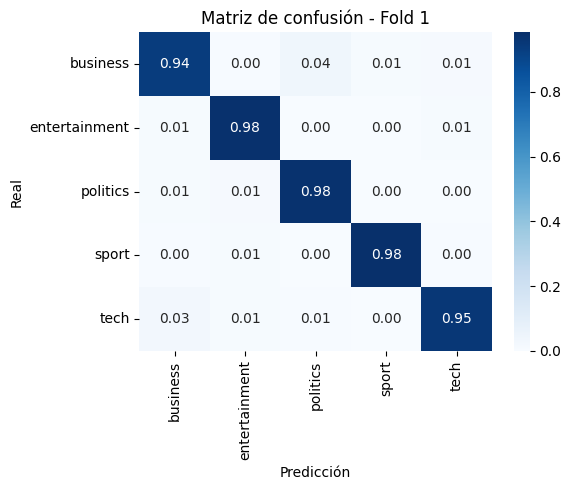

===== Fold 2 =====
[Modo: BERT sin entrenamiento adicional]

Reporte de métricas para el Fold 2
          precision  recall  f1-score   support
0             0.952   0.944     0.948   251.000
1             0.984   0.973     0.978   185.000
2             0.970   0.970     0.970   201.000
3             0.996   0.996     0.996   253.000
4             0.938   0.960     0.949   173.000
5             0.969   0.969     0.969     0.969
6             0.968   0.969     0.968  1063.000
7             0.969   0.969     0.969  1063.000
accuracy      0.969   0.969     0.969  3189.969


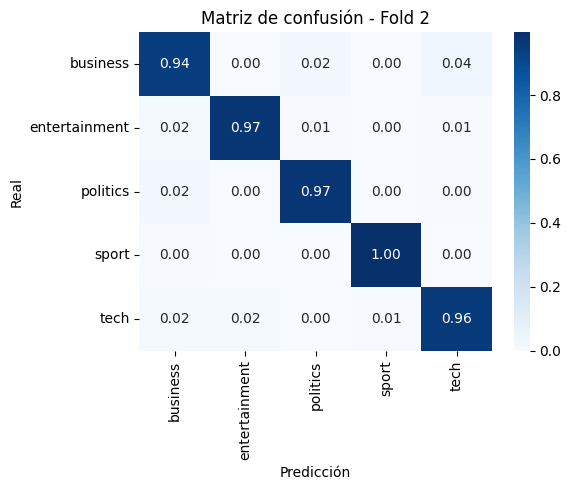

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.964562,0.965497,0.964952,709.547828,0.965226,bert_only
1,2,0.968260,0.968709,0.968459,708.881990,0.968956,bert_only


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,0.959,0.937,0.948,252.000,1,bert_only
1,entertainment,0.957,0.978,0.968,184.000,1,bert_only
2,politics,0.947,0.975,0.961,202.000,1,bert_only
3,sport,0.992,0.984,0.988,252.000,1,bert_only
4,tech,0.965,0.954,0.960,174.000,1,bert_only
5,accuracy,0.965,0.965,0.965,0.965,1,bert_only
6,macro avg,0.964,0.966,0.965,1064.000,1,bert_only
7,weighted avg,0.965,0.965,0.965,1064.000,1,bert_only
8,NaN,0.965,0.965,0.965,3192.965,1,bert_only
9,business,0.952,0.944,0.948,251.000,2,bert_only


In [ ]:
config = {
    'max_len': 128,
    'batch_size': 4,
    'epochs': 3,
    'lr': 2e-5,
    'dropout': 0.3,
    'hidden_dim': 128,
    'num_folds': 2,
    'mode': 'bert_only'  # opciones: 'bert_only', 'bert_finetune', 'bert_with_head', 'bert_frozen_head
}
pipeline = BERTPipeline(config=config)
pipeline.load_dataframe(data ,label_column='labels')
pipeline.train_and_evaluate()

# Pruebas con BERT entrenado con el dataset

A continuación hacemos las pruebas con BERT, incluyendo un finetuning sobre el conjunto de datos.

===== Fold 1 =====
[Modo: BERT con fine-tuning (sin capa adicional)]
Epoch 1/3 - Loss: 0.4772 - Accuracy: 0.9258
Epoch 2/3 - Loss: 0.0852 - Accuracy: 0.9615
Epoch 3/3 - Loss: 0.0272 - Accuracy: 0.9690

Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             0.956   0.952     0.954   252.000
1             0.968   0.973     0.970   184.000
2             0.957   0.980     0.968   202.000
3             0.992   0.996     0.994   252.000
4             0.970   0.937     0.953   174.000
5             0.969   0.969     0.969     0.969
6             0.969   0.968     0.968  1064.000
7             0.969   0.969     0.969  1064.000
accuracy      0.969   0.969     0.969  3192.969


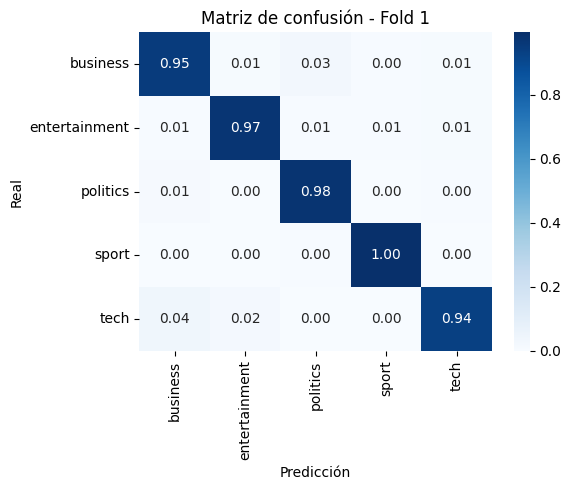

===== Fold 2 =====
[Modo: BERT con fine-tuning (sin capa adicional)]
Epoch 1/3 - Loss: 0.4655 - Accuracy: 0.9680
Epoch 2/3 - Loss: 0.0785 - Accuracy: 0.9737
Epoch 3/3 - Loss: 0.0303 - Accuracy: 0.9784

Reporte de métricas para el Fold 2
          precision  recall  f1-score   support
0             0.957   0.976     0.966   251.000
1             1.000   0.978     0.989   185.000
2             0.980   0.965     0.972   201.000
3             0.996   0.992     0.994   253.000
4             0.960   0.977     0.968   173.000
5             0.978   0.978     0.978     0.978
6             0.979   0.978     0.978  1063.000
7             0.979   0.978     0.978  1063.000
accuracy      0.978   0.978     0.978  3189.978


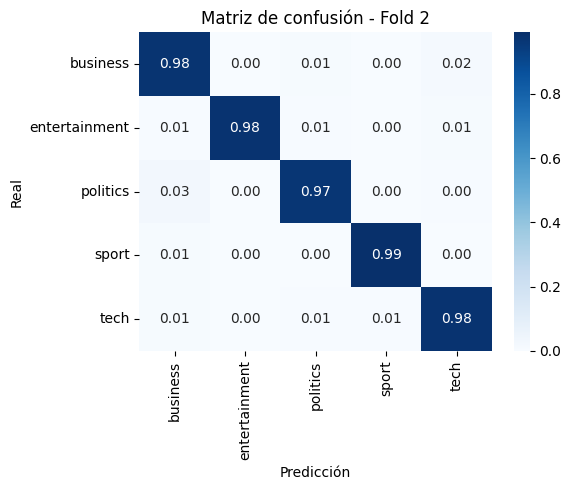

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.968678,0.968091,0.968315,709.548663,0.968985,bert_finetune
1,2,0.978561,0.977937,0.978196,708.884081,0.978363,bert_finetune


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,0.956,0.952,0.954,252.000,1,bert_finetune
1,entertainment,0.968,0.973,0.970,184.000,1,bert_finetune
2,politics,0.957,0.980,0.968,202.000,1,bert_finetune
3,sport,0.992,0.996,0.994,252.000,1,bert_finetune
4,tech,0.970,0.937,0.953,174.000,1,bert_finetune
5,accuracy,0.969,0.969,0.969,0.969,1,bert_finetune
6,macro avg,0.969,0.968,0.968,1064.000,1,bert_finetune
7,weighted avg,0.969,0.969,0.969,1064.000,1,bert_finetune
8,NaN,0.969,0.969,0.969,3192.969,1,bert_finetune
9,business,0.957,0.976,0.966,251.000,2,bert_finetune


In [ ]:
config = {
        'max_len': 128,
        'batch_size': 4,
        'epochs': 3,
        'lr': 2e-5,
        'dropout': 0.3,
        'hidden_dim': 128,
        'num_folds': 2,
        'mode': 'bert_finetune'  # opciones: 'bert_only', 'bert_finetune', 'bert_with_head'
    }
pipeline = BERTPipeline(config=config)
pipeline.load_dataframe(data ,label_column='labels')
pipeline.train_and_evaluate()

# Pruebas con BERT entrenado y la red neuronal como clasificación y dropout 0.3

En esta sección combinamos BERT con una red neuronal como clasificación, con dropout 0.3. Vamos a revisar el resultado cambiando el dropout justo después.

===== Fold 1 =====
[Modo: BERT + red de clasificación]
Epoch 1/3 - Loss: 1.0082 - Accuracy: 0.9709
Epoch 2/3 - Loss: 0.2317 - Accuracy: 0.9624
Epoch 3/3 - Loss: 0.0964 - Accuracy: 0.9690

Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             0.959   0.937     0.948   252.000
1             0.978   0.967     0.973   184.000
2             0.957   0.980     0.968   202.000
3             0.996   0.996     0.996   252.000
4             0.949   0.966     0.957   174.000
5             0.969   0.969     0.969     0.969
6             0.968   0.969     0.968  1064.000
7             0.969   0.969     0.969  1064.000
accuracy      0.969   0.969     0.969  3192.969


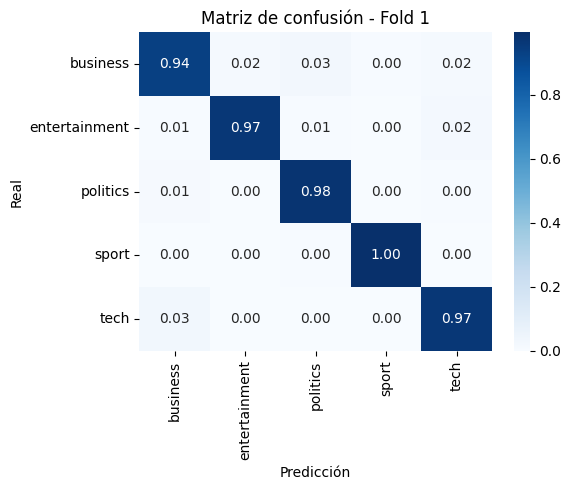

===== Fold 2 =====
[Modo: BERT + red de clasificación]
Epoch 1/3 - Loss: 0.9892 - Accuracy: 0.9341
Epoch 2/3 - Loss: 0.1917 - Accuracy: 0.9643
Epoch 3/3 - Loss: 0.0771 - Accuracy: 0.9652

Reporte de métricas para el Fold 2
          precision  recall  f1-score   support
0             0.983   0.936     0.959   251.000
1             0.989   0.951     0.970   185.000
2             0.951   0.960     0.955   201.000
3             0.958   0.996     0.977   253.000
4             0.944   0.983     0.963   173.000
5             0.965   0.965     0.965     0.965
6             0.965   0.965     0.965  1063.000
7             0.966   0.965     0.965  1063.000
accuracy      0.965   0.965     0.965  3189.965


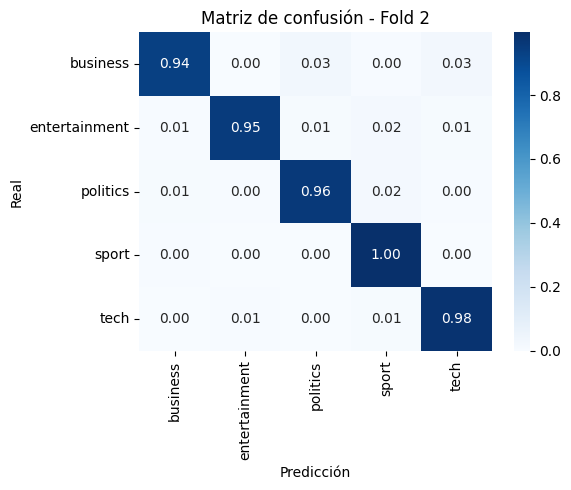

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.968214,0.969081,0.968588,709.548663,0.968985,bert_with_head
1,2,0.965181,0.965266,0.964957,708.881154,0.965193,bert_with_head


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,0.959,0.937,0.948,252.000,1,bert_with_head
1,entertainment,0.978,0.967,0.973,184.000,1,bert_with_head
2,politics,0.957,0.980,0.968,202.000,1,bert_with_head
3,sport,0.996,0.996,0.996,252.000,1,bert_with_head
4,tech,0.949,0.966,0.957,174.000,1,bert_with_head
5,accuracy,0.969,0.969,0.969,0.969,1,bert_with_head
6,macro avg,0.968,0.969,0.968,1064.000,1,bert_with_head
7,weighted avg,0.969,0.969,0.969,1064.000,1,bert_with_head
8,NaN,0.969,0.969,0.969,3192.969,1,bert_with_head
9,business,0.983,0.936,0.959,251.000,2,bert_with_head


In [ ]:
config = {
        'max_len': 128,
        'batch_size': 4,
        'epochs': 3,
        'lr': 2e-5,
        'dropout': 0.3,
        'hidden_dim': 128,
        'num_folds': 2,
        'mode': 'bert_with_head'  # opciones: 'bert_only', 'bert_finetune', 'bert_with_head'
    }
pipeline = BERTPipeline(config=config)
pipeline.load_dataframe(data ,label_column='labels')
pipeline.train_and_evaluate()

# Prueba BERT y un dropout de 0.5

===== Fold 1 =====
[Modo: BERT + red de clasificación]
Epoch 1/3 - Loss: 1.0818 - Accuracy: 0.9690
Epoch 2/3 - Loss: 0.2676 - Accuracy: 0.9577
Epoch 3/3 - Loss: 0.1142 - Accuracy: 0.9314

Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             0.913   0.913     0.913   252.000
1             0.973   0.962     0.967   184.000
2             0.971   0.832     0.896   202.000
3             0.909   0.996     0.951   252.000
4             0.912   0.948     0.930   174.000
5             0.931   0.931     0.931     0.931
6             0.935   0.930     0.931  1064.000
7             0.933   0.931     0.931  1064.000
accuracy      0.931   0.931     0.931  3192.931


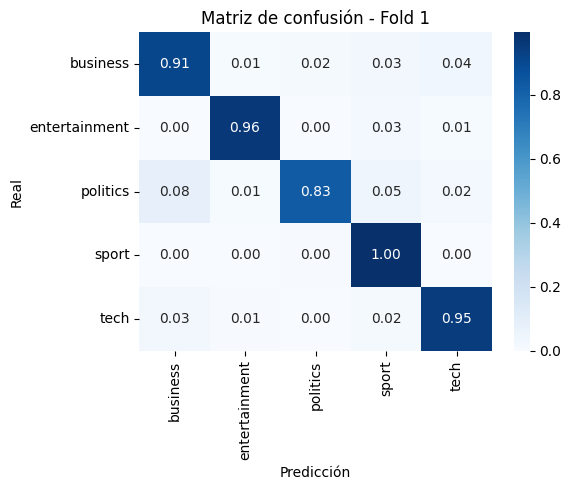

===== Fold 2 =====
[Modo: BERT + red de clasificación]
Epoch 1/3 - Loss: 1.2192 - Accuracy: 0.9407
Epoch 2/3 - Loss: 0.3102 - Accuracy: 0.9483
Epoch 3/3 - Loss: 0.1041 - Accuracy: 0.9699

Reporte de métricas para el Fold 2
          precision  recall  f1-score  support
0             0.968   0.956     0.962   251.00
1             0.968   0.978     0.973   185.00
2             0.975   0.955     0.965   201.00
3             0.977   0.992     0.984   253.00
4             0.960   0.965     0.963   173.00
5             0.970   0.970     0.970     0.97
6             0.969   0.969     0.969  1063.00
7             0.970   0.970     0.970  1063.00
accuracy      0.970   0.970     0.970  3189.97


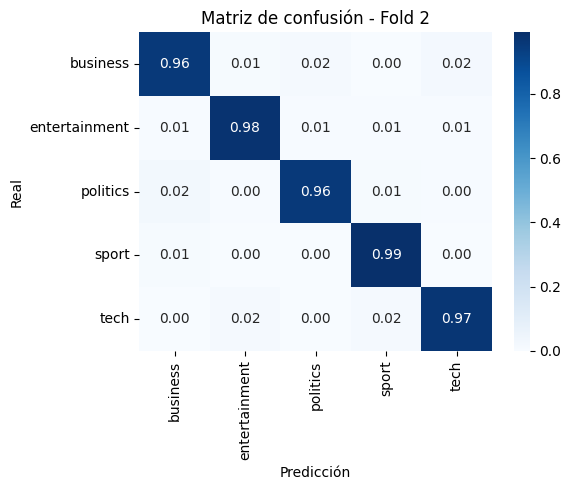

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.934308,0.930550,0.931223,709.540309,0.931391,bert_with_head
1,2,0.969525,0.969591,0.969522,708.882199,0.969897,bert_with_head


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,0.913,0.913,0.913,252.000,1,bert_with_head
1,entertainment,0.973,0.962,0.967,184.000,1,bert_with_head
2,politics,0.971,0.832,0.896,202.000,1,bert_with_head
3,sport,0.909,0.996,0.951,252.000,1,bert_with_head
4,tech,0.912,0.948,0.930,174.000,1,bert_with_head
5,accuracy,0.931,0.931,0.931,0.931,1,bert_with_head
6,macro avg,0.935,0.930,0.931,1064.000,1,bert_with_head
7,weighted avg,0.933,0.931,0.931,1064.000,1,bert_with_head
8,NaN,0.931,0.931,0.931,3192.931,1,bert_with_head
9,business,0.968,0.956,0.962,251.000,2,bert_with_head


In [ ]:
if __name__ == "__main__":
    config = {
        'max_len': 128,
        'batch_size': 4,
        'epochs': 3,
        'lr': 2e-5,
        'dropout': 0.5,
        'hidden_dim': 128,
        'num_folds': 2,
        'mode': 'bert_with_head'  # opciones: 'bert_only', 'bert_finetune', 'bert_with_head'
    }
    pipeline = BERTPipeline(config=config)
    pipeline.load_dataframe(data ,label_column='labels')
    pipeline.train_and_evaluate()

# Prueba con BERT congelado

En esta parte, queremos ver, ¿Cómo le iría únicamente a nuestra red con BERT congelado? En otras palabras, si utilizáramos sólo nuestro modelo entrenado, cuáles serían las métricas.

===== Fold 1 =====
[Modo: BERT congelado + red de clasificación]
Epoch 1/3 - Loss: 1.6367 - Accuracy: 0.2904
Epoch 2/3 - Loss: 1.5698 - Accuracy: 0.3158
Epoch 3/3 - Loss: 1.5418 - Accuracy: 0.3628

Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             0.303   0.948     0.459   252.000
1             0.400   0.033     0.060   184.000
2             0.000   0.000     0.000   202.000
3             0.542   0.560     0.551   252.000
4             0.000   0.000     0.000   174.000
5             0.363   0.363     0.363     0.363
6             0.249   0.308     0.214  1064.000
7             0.269   0.363     0.250  1064.000
accuracy      0.363   0.363     0.363  3192.363


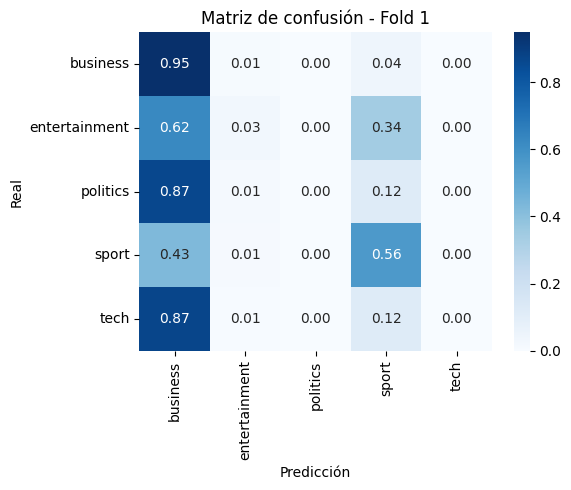

===== Fold 2 =====
[Modo: BERT congelado + red de clasificación]
Epoch 1/3 - Loss: 1.6319 - Accuracy: 0.2361
Epoch 2/3 - Loss: 1.5701 - Accuracy: 0.3198
Epoch 3/3 - Loss: 1.5420 - Accuracy: 0.3631

Reporte de métricas para el Fold 2
          precision  recall  f1-score   support
0             0.298   0.920     0.450   251.000
1             1.000   0.043     0.083   185.000
2             0.000   0.000     0.000   201.000
3             0.537   0.577     0.556   253.000
4             0.143   0.006     0.011   173.000
5             0.363   0.363     0.363     0.363
6             0.395   0.309     0.220  1063.000
7             0.395   0.363     0.255  1063.000
accuracy      0.363   0.363     0.363  3189.363


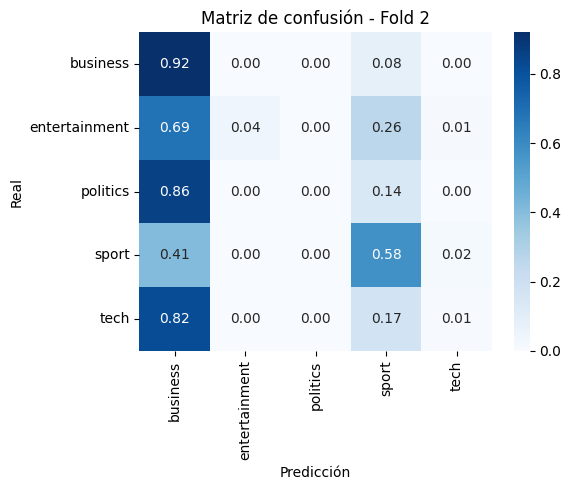

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.276577,0.326333,0.251056,709.413952,0.362782,bert_frozen_head
1,2,0.388260,0.327230,0.255683,708.747361,0.363123,bert_frozen_head


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,0.303,0.948,0.459,252.000,1,bert_frozen_head
1,entertainment,0.400,0.033,0.060,184.000,1,bert_frozen_head
2,politics,0.000,0.000,0.000,202.000,1,bert_frozen_head
3,sport,0.542,0.560,0.551,252.000,1,bert_frozen_head
4,tech,0.000,0.000,0.000,174.000,1,bert_frozen_head
5,accuracy,0.363,0.363,0.363,0.363,1,bert_frozen_head
6,macro avg,0.249,0.308,0.214,1064.000,1,bert_frozen_head
7,weighted avg,0.269,0.363,0.250,1064.000,1,bert_frozen_head
8,NaN,0.363,0.363,0.363,3192.363,1,bert_frozen_head
9,business,0.298,0.920,0.450,251.000,2,bert_frozen_head


In [ ]:
config = {
    'max_len': 128,
    'batch_size': 4,
    'epochs': 3,
    'lr': 2e-5,
    'dropout': 0.5,
    'hidden_dim': 128,
    'num_folds': 2,
    'mode': 'bert_frozen_head'
}
pipeline = BERTPipeline(config=config)
pipeline.load_dataframe(data ,label_column='labels')
pipeline.train_and_evaluate()

# Comparación entre los diferentes enfoques

## Ejecución con Gráficos de Comparación

Aquí usamos el conjunto original, de la copia que tomamos al comienzo del notebook, con el objetivo de ejecutar todo el pipeline, generando un conjunto de test, de tal manera que podamos validar sobre este conjunto y generar una serie de gráficas que nos permitan comparar los enfoques que hemos tomado. Recordemos que

```
df_data
```
es una copia de


```
data
```




A continuación queremos asegurarnos de que evaluamos sobre un conjunto de test, utilizando el pipeline que creamos. También, hemos generado archivos de pickle para que podamos evaluar después, sin tener que volver a entrenar todo cada vez.

### Entrenamiento de todos los modos a través del Pipeline

En esta celda mostramos un entrenamiento de todos los modos (enfoques) utilizando la misma configuración con el objetivo de generar una comparación de métricas, lo cual hemos visto en detalle en el entrenamiento de cada enfoque individual en la parte de arriba.

In [ ]:
pickle_dir = os.path.join(data_dir, "pipelines_guardados")

In [ ]:
os.makedirs(pickle_dir, exist_ok=True)

In [ ]:
df_data = data.copy()


===== Entrenando modo: bert_only =====
===== Fold 1 =====
[Modo: BERT sin entrenamiento adicional]

Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             0.967   0.953     0.960   214.000
1             0.993   0.962     0.977   157.000
2             0.950   0.994     0.971   171.000
3             1.000   0.995     0.998   214.000
4             0.953   0.959     0.956   148.000
5             0.973   0.973     0.973     0.973
6             0.973   0.973     0.973   904.000
7             0.974   0.973     0.973   904.000
accuracy      0.973   0.973     0.973  2712.973


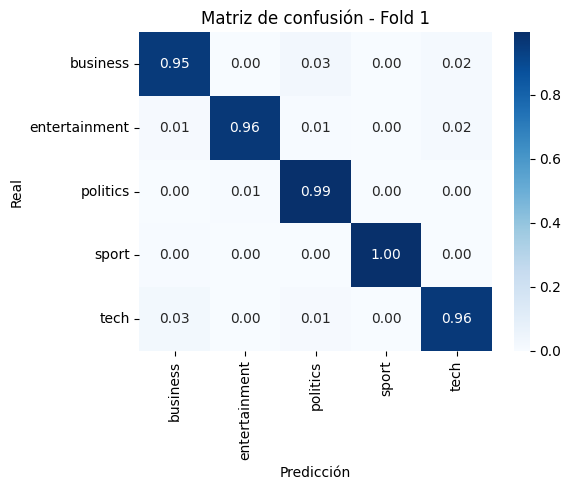

===== Fold 2 =====
[Modo: BERT sin entrenamiento adicional]

Reporte de métricas para el Fold 2
          precision  recall  f1-score   support
0             0.912   0.967     0.938   213.000
1             0.974   0.968     0.971   157.000
2             0.963   0.912     0.937   171.000
3             0.995   0.981     0.988   215.000
4             0.932   0.932     0.932   147.000
5             0.955   0.955     0.955     0.955
6             0.955   0.952     0.953   903.000
7             0.955   0.955     0.955   903.000
accuracy      0.955   0.955     0.955  2709.955


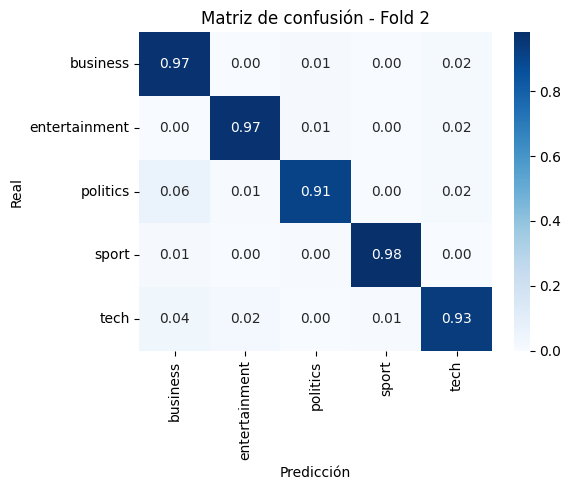

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.972921,0.973016,0.972841,602.882989,0.973451,bert_only
1,2,0.955105,0.952990,0.953801,602.212132,0.954596,bert_only


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,0.967,0.953,0.960,214.000,1,bert_only
1,entertainment,0.993,0.962,0.977,157.000,1,bert_only
2,politics,0.950,0.994,0.971,171.000,1,bert_only
3,sport,1.000,0.995,0.998,214.000,1,bert_only
4,tech,0.953,0.959,0.956,148.000,1,bert_only
5,accuracy,0.973,0.973,0.973,0.973,1,bert_only
6,macro avg,0.973,0.973,0.973,904.000,1,bert_only
7,weighted avg,0.974,0.973,0.973,904.000,1,bert_only
8,NaN,0.973,0.973,0.973,2712.973,1,bert_only
9,business,0.912,0.967,0.938,213.000,2,bert_only



===== Entrenando modo: bert_finetune =====
===== Fold 1 =====
[Modo: BERT con fine-tuning (sin capa adicional)]
Epoch 1/3 - Loss: 0.9644 - Accuracy: 0.9624
Epoch 2/3 - Loss: 0.1770 - Accuracy: 0.9679
Epoch 3/3 - Loss: 0.0509 - Accuracy: 0.9635

Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             0.985   0.893     0.936   214.000
1             1.000   0.968     0.984   157.000
2             0.864   1.000     0.927   171.000
3             1.000   1.000     1.000   214.000
4             0.979   0.966     0.973   148.000
5             0.963   0.963     0.963     0.963
6             0.966   0.965     0.964   904.000
7             0.967   0.963     0.964   904.000
accuracy      0.963   0.963     0.963  2712.963


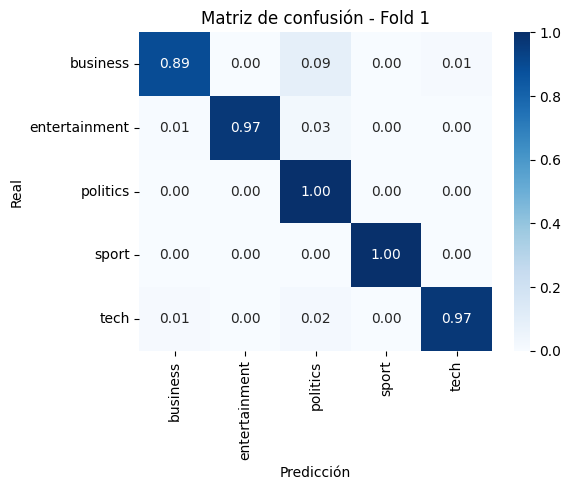

===== Fold 2 =====
[Modo: BERT con fine-tuning (sin capa adicional)]
Epoch 1/3 - Loss: 0.9507 - Accuracy: 0.9690
Epoch 2/3 - Loss: 0.1415 - Accuracy: 0.9590
Epoch 3/3 - Loss: 0.0403 - Accuracy: 0.9779

Reporte de métricas para el Fold 2
          precision  recall  f1-score   support
0             0.950   0.977     0.963   213.000
1             1.000   0.981     0.990   157.000
2             0.982   0.953     0.967   171.000
3             0.995   0.991     0.993   215.000
4             0.967   0.986     0.976   147.000
5             0.978   0.978     0.978     0.978
6             0.979   0.978     0.978   903.000
7             0.978   0.978     0.978   903.000
accuracy      0.978   0.978     0.978  2709.978


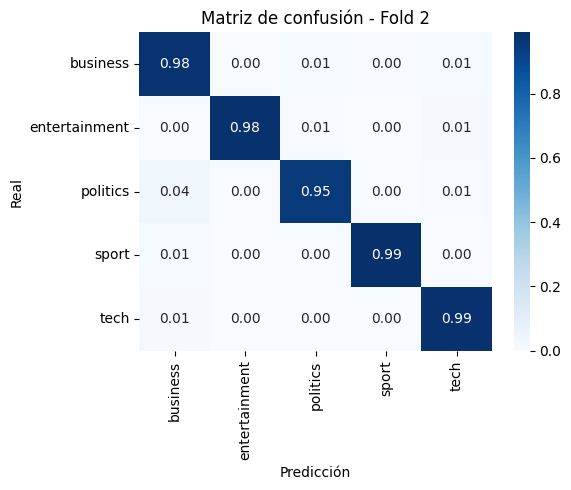

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.965258,0.964751,0.963828,602.880777,0.963496,bert_finetune
1,2,0.978481,0.977647,0.977971,602.217300,0.977852,bert_finetune


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,0.985,0.893,0.936,214.000,1,bert_finetune
1,entertainment,1.000,0.968,0.984,157.000,1,bert_finetune
2,politics,0.864,1.000,0.927,171.000,1,bert_finetune
3,sport,1.000,1.000,1.000,214.000,1,bert_finetune
4,tech,0.979,0.966,0.973,148.000,1,bert_finetune
5,accuracy,0.963,0.963,0.963,0.963,1,bert_finetune
6,macro avg,0.966,0.965,0.964,904.000,1,bert_finetune
7,weighted avg,0.967,0.963,0.964,904.000,1,bert_finetune
8,NaN,0.963,0.963,0.963,2712.963,1,bert_finetune
9,business,0.950,0.977,0.963,213.000,2,bert_finetune



===== Entrenando modo: bert_with_head =====
===== Fold 1 =====
[Modo: BERT + red de clasificación]
Epoch 1/3 - Loss: 1.4018 - Accuracy: 0.9447
Epoch 2/3 - Loss: 0.6187 - Accuracy: 0.9746
Epoch 3/3 - Loss: 0.2504 - Accuracy: 0.9757

Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             1.000   0.916     0.956   214.000
1             0.975   1.000     0.987   157.000
2             0.944   0.988     0.966   171.000
3             0.986   1.000     0.993   214.000
4             0.967   0.986     0.977   148.000
5             0.976   0.976     0.976     0.976
6             0.974   0.978     0.976   904.000
7             0.976   0.976     0.975   904.000
accuracy      0.976   0.976     0.976  2712.976


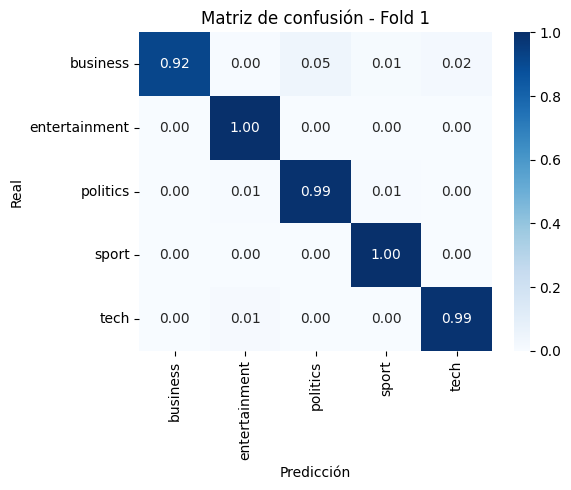

===== Fold 2 =====
[Modo: BERT + red de clasificación]
Epoch 1/3 - Loss: 1.4445 - Accuracy: 0.8206
Epoch 2/3 - Loss: 0.7097 - Accuracy: 0.9646
Epoch 3/3 - Loss: 0.2592 - Accuracy: 0.9745

Reporte de métricas para el Fold 2
          precision  recall  f1-score   support
0             0.949   0.962     0.956   213.000
1             0.981   0.987     0.984   157.000
2             0.982   0.947     0.964   171.000
3             1.000   0.995     0.998   215.000
4             0.960   0.980     0.970   147.000
5             0.975   0.975     0.975     0.975
6             0.974   0.974     0.974   903.000
7             0.975   0.975     0.975   903.000
accuracy      0.975   0.975     0.975  2709.975


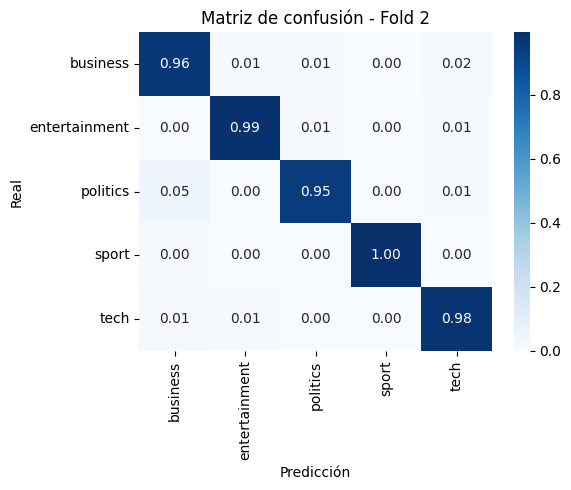

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.974953,0.977312,0.975713,602.883481,0.975664,bert_with_head
1,2,0.974453,0.974445,0.974376,602.216562,0.974529,bert_with_head


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,1.000,0.916,0.956,214.000,1,bert_with_head
1,entertainment,0.975,1.000,0.987,157.000,1,bert_with_head
2,politics,0.944,0.988,0.966,171.000,1,bert_with_head
3,sport,0.986,1.000,0.993,214.000,1,bert_with_head
4,tech,0.967,0.986,0.977,148.000,1,bert_with_head
5,accuracy,0.976,0.976,0.976,0.976,1,bert_with_head
6,macro avg,0.974,0.978,0.976,904.000,1,bert_with_head
7,weighted avg,0.976,0.976,0.975,904.000,1,bert_with_head
8,NaN,0.976,0.976,0.976,2712.976,1,bert_with_head
9,business,0.949,0.962,0.956,213.000,2,bert_with_head



===== Entrenando modo: bert_frozen_head =====
===== Fold 1 =====
[Modo: BERT congelado + red de clasificación]
Epoch 1/3 - Loss: 1.6079 - Accuracy: 0.2854
Epoch 2/3 - Loss: 1.5774 - Accuracy: 0.3064
Epoch 3/3 - Loss: 1.5584 - Accuracy: 0.3462

Reporte de métricas para el Fold 1
          precision  recall  f1-score   support
0             0.294   0.916     0.445   214.000
1             0.250   0.006     0.012   157.000
2             0.000   0.000     0.000   171.000
3             0.500   0.542     0.520   214.000
4             0.000   0.000     0.000   148.000
5             0.346   0.346     0.346     0.346
6             0.209   0.293     0.196   904.000
7             0.231   0.346     0.231   904.000
accuracy      0.346   0.346     0.346  2712.346


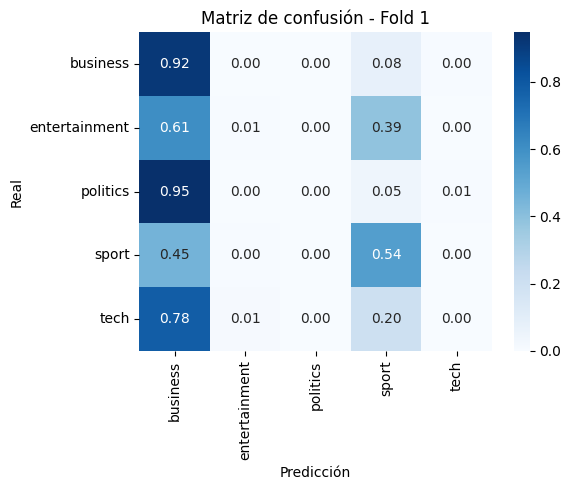

===== Fold 2 =====
[Modo: BERT congelado + red de clasificación]
Epoch 1/3 - Loss: 1.6182 - Accuracy: 0.2536
Epoch 2/3 - Loss: 1.5787 - Accuracy: 0.3178
Epoch 3/3 - Loss: 1.5590 - Accuracy: 0.3998

Reporte de métricas para el Fold 2
          precision  recall  f1-score  support
0             0.308   0.958     0.466    213.0
1             0.571   0.102     0.173    157.0
2             0.000   0.000     0.000    171.0
3             0.665   0.656     0.660    215.0
4             0.000   0.000     0.000    147.0
5             0.400   0.400     0.400      0.4
6             0.309   0.343     0.260    903.0
7             0.330   0.400     0.297    903.0
accuracy      0.400   0.400     0.400   2709.4


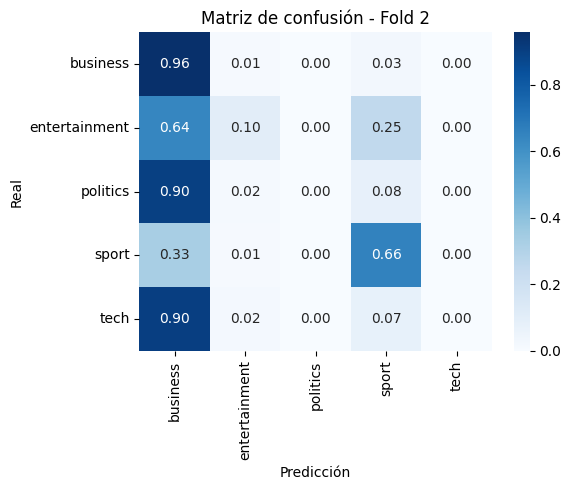

=== Resumen Promedio por Fold (Todas las métricas + Accuracy) ===


,Fold,precision,recall,f1-score,support,accuracy,scenario
0,1,0.241898,0.310655,0.232988,602.743609,0.346239,bert_frozen_head
1,2,0.331433,0.361989,0.295079,602.088840,0.399779,bert_frozen_head


=== Todas las métricas por Fold ===


,Clase,precision,recall,f1-score,support,Fold,scenario
0,business,0.294,0.916,0.445,214.000,1,bert_frozen_head
1,entertainment,0.250,0.006,0.012,157.000,1,bert_frozen_head
2,politics,0.000,0.000,0.000,171.000,1,bert_frozen_head
3,sport,0.500,0.542,0.520,214.000,1,bert_frozen_head
4,tech,0.000,0.000,0.000,148.000,1,bert_frozen_head
5,accuracy,0.346,0.346,0.346,0.346,1,bert_frozen_head
6,macro avg,0.209,0.293,0.196,904.000,1,bert_frozen_head
7,weighted avg,0.231,0.346,0.231,904.000,1,bert_frozen_head
8,NaN,0.346,0.346,0.346,2712.346,1,bert_frozen_head
9,business,0.308,0.958,0.466,213.000,2,bert_frozen_head


In [ ]:
from sklearn.model_selection import train_test_split
import torch, pickle, os
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ========= Dividiendo el dataset =========
df_train, df_test = train_test_split(
    df_data,
    test_size=0.15,
    stratify=df_data['labels'],
    random_state=42
)

# ========= Entrenar todos los modos =========
os.makedirs("pipelines_guardados", exist_ok=True)
modos = ['bert_only', 'bert_finetune', 'bert_with_head','bert_frozen_head']
pipelines = []

for modo in modos:
    print(f"\n===== Entrenando modo: {modo} =====")
    config = {
        'mode': modo,
        'num_folds': 2,
        'epochs': 3,
        'batch_size': 16,
        'lr': 2e-5,
        'dropout': 0.3,
        'hidden_dim': 128,
        'max_len': 256,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
    pipeline = BERTPipeline(config=config)
    pipeline.load_dataframe(df_train, label_column='labels')
    pipeline.train_and_evaluate()

    #Ejecutamos esta parte para guardar la ejecución para no tener que volver a
    #entrenar desde 0 para evaluar, en caso de que se pierda la sesión.
    with open(os.path.join(pickle_dir, f"pipeline_{modo}.pkl"), "wb") as f:
        pickle.dump(pipeline, f)

    pipelines.append(pipeline)


### Evaluación en conjunto de test

En la primera parte del notebook,  hicimos entrenamiento y evaluación sobre  en los conjuntos de validación. En esta sección hacemos evaluación sobre el conjunto de test, posteriormente a haber hecho un nuevo split del conjunto original.


=== Evaluando en test: bert_only ===
[Modo: BERT only + regresión logística (sklearn)]

=== Reporte de clasificación ===
               precision    recall  f1-score   support

     business       0.95      0.97      0.96        76
entertainment       0.96      0.96      0.96        55
     politics       0.96      0.90      0.93        61
        sport       1.00      1.00      1.00        76
         tech       0.93      0.96      0.94        52

     accuracy                           0.96       320
    macro avg       0.96      0.96      0.96       320
 weighted avg       0.96      0.96      0.96       320



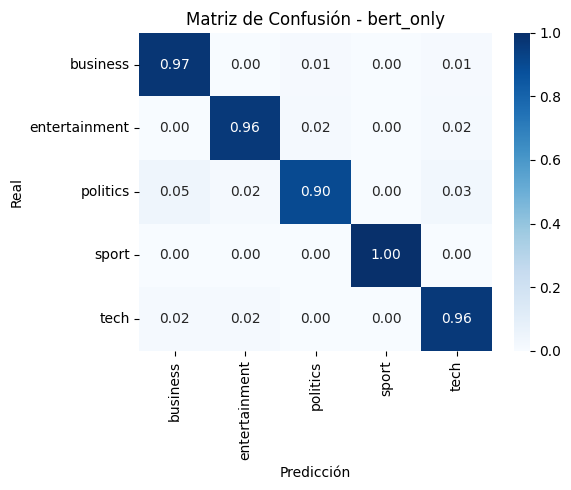


=== Evaluando en test: bert_finetune ===
[Modo: bert_finetune (modelo PyTorch)]

=== Reporte de clasificación ===
               precision    recall  f1-score   support

     business       0.94      0.99      0.96        76
entertainment       0.96      0.98      0.97        55
     politics       1.00      0.90      0.95        61
        sport       1.00      1.00      1.00        76
         tech       0.94      0.96      0.95        52

     accuracy                           0.97       320
    macro avg       0.97      0.97      0.97       320
 weighted avg       0.97      0.97      0.97       320



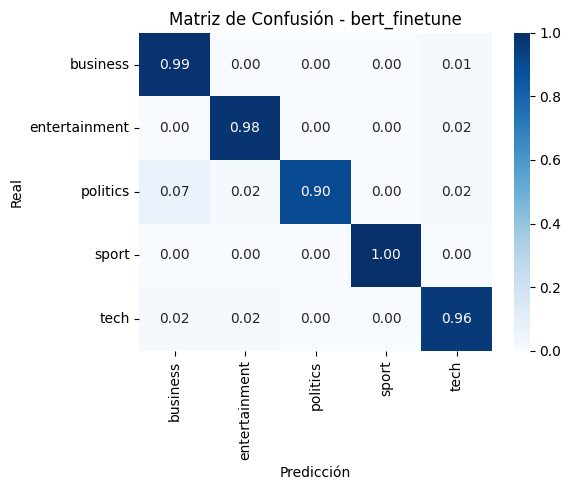


=== Evaluando en test: bert_with_head ===
[Modo: bert_with_head (modelo PyTorch)]

=== Reporte de clasificación ===
               precision    recall  f1-score   support

     business       0.97      0.97      0.97        76
entertainment       0.96      0.98      0.97        55
     politics       1.00      0.93      0.97        61
        sport       1.00      1.00      1.00        76
         tech       0.93      0.98      0.95        52

     accuracy                           0.97       320
    macro avg       0.97      0.97      0.97       320
 weighted avg       0.98      0.97      0.98       320



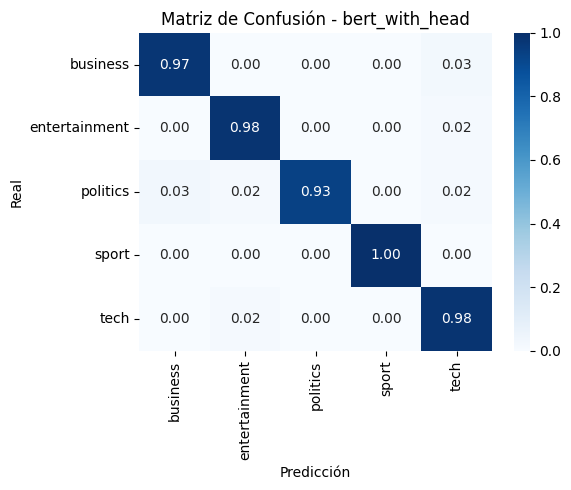


=== Evaluando en test: bert_frozen_head ===
[Modo: bert_frozen_head (modelo PyTorch)]

=== Reporte de clasificación ===
               precision    recall  f1-score   support

     business       0.29      0.91      0.44        76
entertainment       0.50      0.07      0.13        55
     politics       0.00      0.00      0.00        61
        sport       0.59      0.58      0.58        76
         tech       0.00      0.00      0.00        52

     accuracy                           0.37       320
    macro avg       0.28      0.31      0.23       320
 weighted avg       0.29      0.37      0.26       320



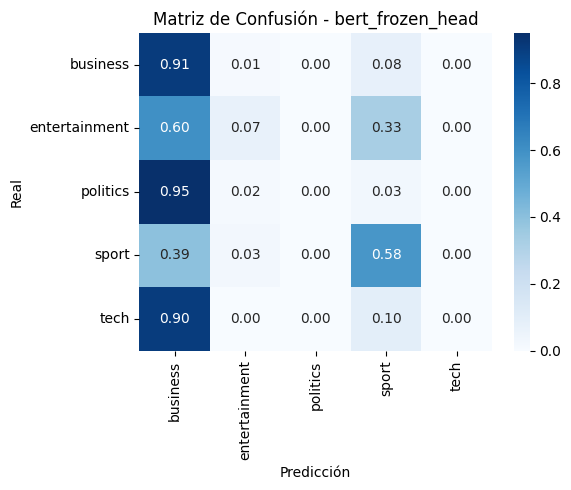

In [ ]:
resultados_test = []

for pipeline in pipelines:
    print(f"\n=== Evaluando en test: {pipeline.mode} ===")
    resumen = pipeline.evaluate_test(df_test)  # cada pipeline maneja su propio modelo y modo
    resultados_test.append(resumen)

### Gráficos Comparativos

Este gráfico comparativo muestra las diferentes métricas comparadas de acuerdo con el rendimiento de cada uno de los enfoques, utilizando la misma configuración y basado en la evaluación sobre el conjunto de test (no los conjuntos de validación.


Resumen comparativo de métricas en test:


,escenario,accuracy,precision,recall,f1-score
0,bert_only,0.962,0.963,0.962,0.962
1,bert_finetune,0.969,0.970,0.969,0.969
2,bert_with_head,0.975,0.976,0.975,0.975
3,bert_frozen_head,0.366,0.294,0.366,0.265


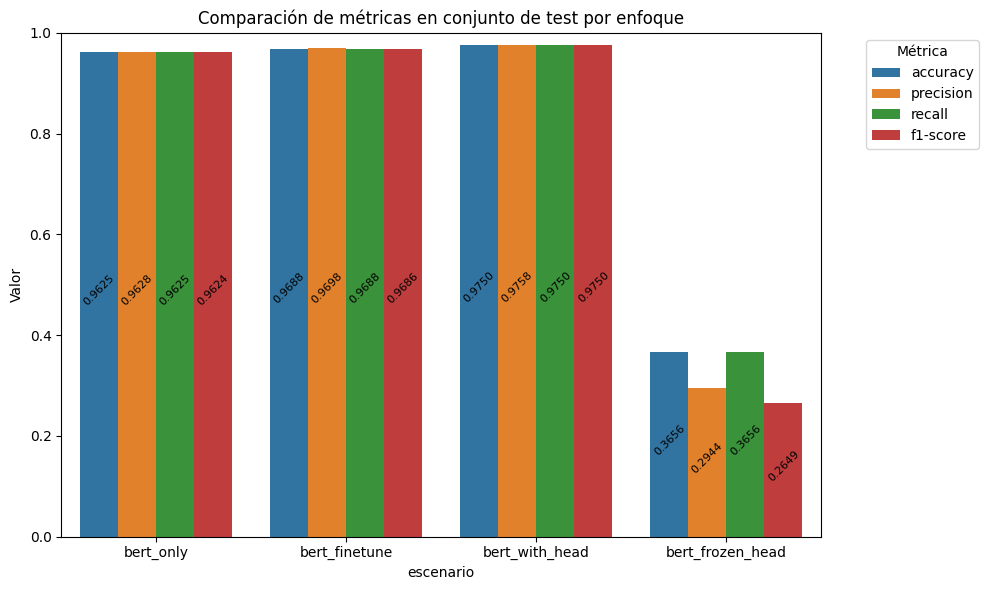

In [ ]:
df_resumen = pd.DataFrame(resultados_test)
print("\nResumen comparativo de métricas en test:")
display(df_resumen.round(3))

df_resultados = pd.DataFrame(resultados_test)
df_melt = df_resultados.melt(id_vars='escenario', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melt, x='escenario', y='Valor', hue='Métrica')

# Etiquetas encima en diagonal y con fuente más pequeña
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.4f',
        padding=3,
        label_type='center',
        rotation=45,
        fontsize=8
    )

plt.title("Comparación de métricas en conjunto de test por enfoque")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Resultados y Conclusiones



*   **BERT con la red neuronal (BERT with head) parece ser la mejor combinación**: Los modelos que incluyen el modelo preentrenado tiene muy buenas métricas, sin embargo,las que combinan el modelo BERT con la red neuronal que hemos creado, incrementan el rendimiento del modelo.
*   **BERT con la red neuronal parece tener un leve mejor desempeño con dropout 0.3**: Lo podemos ver en las métricas con dropout 0.5 , en la matriz de confusión, levemente más bajas para 'business' y 'politics. Por esto utilizamos 0.3 como parámetro en el entrenamiento general sobre el conjunto de test
*   **BERT only tiene muy buenas métricas y podría utilizarse sin finetuning**:A pesar de que el modelo con fine-tunning o el modelo con la red neuronal tienen mejor rendimiento, el modelo preentrenado podría usarse para la clasificación perfectamente. Esto nos dice que es necesario combinar el modelo para casos en los que necesitamos una aplicación específica y requerimos, por negocio, dar unos resultados a medida.Si no es así podríamos utilizar el modelo preentrenado directamente y obtendríamos un buen resultado.
* **El uso de la red neuronal no tiene buen rendimiento por sí misma**: La red ad-hoc que hemos combinado con BERT, tendría que pasar por el proceso de entrenamiento en varias épocas; optimizada con los mejores parámetros y probablemente requeriría ser entrenada sobre una gran cantidad de datos para lograr los mismos resultados. Las métricas de BERT congelado y sus matrices de confusión, nos muestran que la red neuronal por sí misma no muestra una clasificación eficiente.

